/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:38:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 90.15%
Precision: 0.9077
Recall: 0.8941
F1 Score: 0.9009
ROC-AUC: 0.9695

Classification Report:

              precision    recall  f1-score   support

       <=50K       0.90      0.91      0.90      4938
        >50K       0.91      0.89      0.90      4950

    accuracy                           0.90      9888
   macro avg       0.90      0.90      0.90      9888
weighted avg       0.90      0.90      0.90      9888



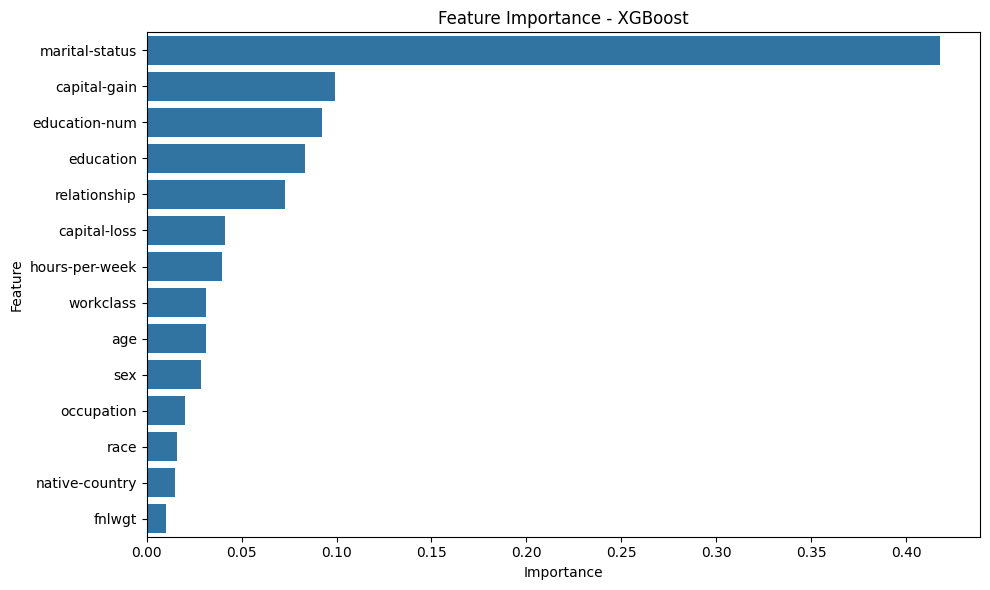

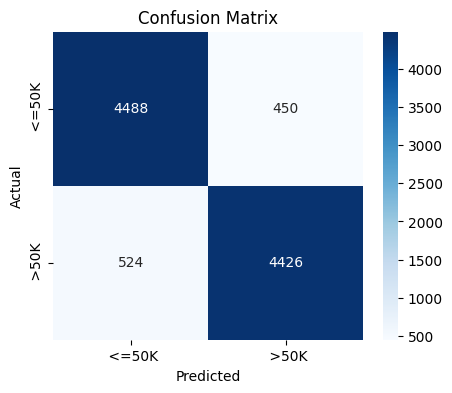

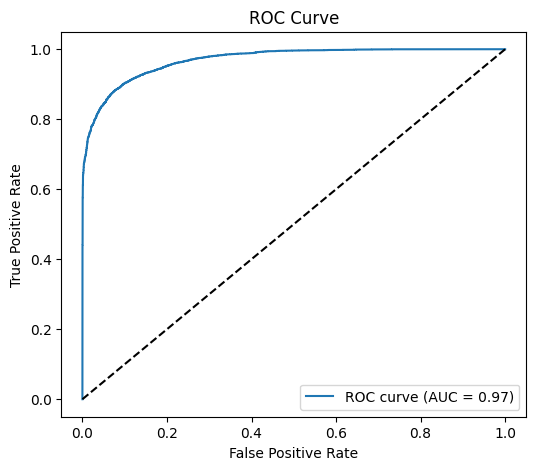

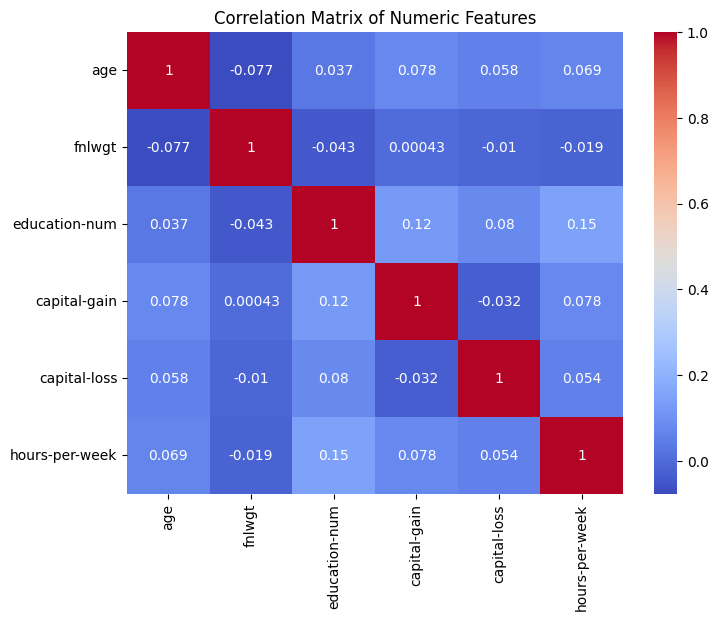

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    f1_score, precision_score, recall_score, classification_report
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load data
# -----------------------------
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

data = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
    names=column_names,
    sep=',', engine='python', na_values='?'
)
data = data.dropna()

# -----------------------------
# 2. Preprocessing
# -----------------------------
# Encode categorical features
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')  # exclude target
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Encode target
le_target = LabelEncoder()
data['income'] = le_target.fit_transform(data['income'])

# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# SMOTE oversampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Scale numeric features
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# -----------------------------
# 3. Train XGBoost
# -----------------------------
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# -----------------------------
# 4. Predictions and Accuracy
# -----------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_prob)[:2])

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# -----------------------------
# 5. Feature Importance
# -----------------------------
importance = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# 7. ROC Curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# 8. Correlation Matrix (numeric features)
# -----------------------------
corr_matrix = X[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()
